# A/B–тестирование
### Условие

В ходе A/B–тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. Необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

### Входные данные

* groups.csv – файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 

* groups_add.csv – дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных

* active_studs.csv – файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 

* checks.csv – файл с информацией об оплатах пользователей в дни проведения эксперимента. 


In [28]:
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.stats.proportion import proportions_ztest
import pingouin as pg

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Публичные ссылки на файлы

groups_link = 'https://disk.yandex.ru/d/UhyYx41rTt3clQ'
groups_add_link = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'
active_studs_link = 'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'
checks_link = 'https://disk.yandex.ru/d/pH1q-VqcxXjsVA'

In [3]:
# Функция возвращает датафрейм, прочитанный из CSV-файла по публичной ссылке с Яндекс Диска

def get_file_content(public_link, delimiter=','):
    
    api_url = "https://cloud-api.yandex.net/v1/disk/public/resources/download"
    params = {"public_key": public_link}
    response = requests.get(api_url, params=params)

    if response.status_code == 200:
        download_url = response.json().get("href")
        try:
            df = pd.read_csv(download_url, delimiter=delimiter)
            return df
        except Exception as e:
            print(f"Ошибка при чтении CSV: {e}")
            return None
    else:
        print("Ошибка при получении ссылки:", response.json())
        return None

In [4]:
# Применяем функцию для счиывания ссылок

groups = get_file_content(groups_link, delimiter=';')
groups_add = get_file_content(groups_add_link)
active_studs = get_file_content(active_studs_link)
checks = get_file_content(checks_link, delimiter=';')

In [5]:
print(groups.info())
print(groups.head(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB
None
     id grp
0  1489   B
1  1627   A
2  1768   B


In [6]:
print(groups_add.head(3))
print(groups_add.info())

        id grp
0  5694584   B
1  5694830   B
2  5695057   B
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      92 non-null     int64 
 1   grp     92 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.6+ KB
None


In [7]:
print(checks.head(3))
print(checks.info())

   student_id    rev
0        1627  990.0
1        3185  690.0
2       25973  690.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB
None


In [8]:
print(active_studs.head(3))
print(active_studs.info())
print(active_studs.nunique())

   student_id
0      581585
1     5723133
2     3276743
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB
None
student_id    8341
dtype: int64


In [9]:
# Объедииним таблицы с данными о принадлежности пользователей к группам

groups_full = pd.concat([groups, groups_add], ignore_index=True).drop_duplicates()

In [10]:
# Проведем проверку на баги

# Находим пользователей, которые оплатили
paying_users = set(checks['student_id'])

# Находим пользователей, которые были активны
active = set(active_studs['student_id'])

# Находим тех, кто оплатил, но не был активен
paying_but_not_active = paying_users - active

# Выводим результат
result = checks[checks['student_id'].isin(paying_but_not_active)]
result

,student_id,rev
1,3185,690.0
2,25973,690.0
3,26280,690.0
5,100645,630.0
6,102534,580.0
...,...,...
508,5291900,199.0
512,5331842,290.0
521,5486319,199.0
530,5562806,398.0


149 пользователей совершили оплату, не заходя при этом на сайт. Возможно, это автоматическое списание за подписки, либо баг. В любом случае, если пользователь не заходил на платфоррму в дни теста, он не мог увидеть новую механику оплаты. Будем работать только с активными пользователями.

In [11]:
# Объединим таблицы, оставив только уникальных активных пользователей. 

active_users = groups_full[groups_full['id'].isin(active)]

# Для удобства переименум колонку

checks = checks.rename(columns={'student_id': 'id'})

df = active_users.merge(checks, how='left', on='id').fillna(0)

In [12]:
# Добавим колонку для удобства подсчета платящих пользователей 

df['is_paying'] = df.rev.apply(lambda x: 'yes'if x > 0 else 'no')

Посмотрим на размеры групп и распределение платящих, а также вычислим метрики:

1. **Конверсия (СR)** —  доля пользователей, совершивших оплату (rev > 0), от общего числа активных. Показывает, сколько людей реально заплатили.
2. **Средняя выручка на пользователя (ARPU)** —  rev.mean(). Для отражения общей эффективности.
3. **Средняя выручка на оплатившего пользователя (ARPPU)** — rev.mean() только для тех, у кого rev > 0. Покажет, изменился ли средний чек.

In [13]:
# Посмотрим на размеры групп и распределение платящих

df.groupby('grp').id.count()

grp
A    1538
B    6803
Name: id, dtype: int64

In [14]:
groups_summary = df.groupby(['grp', 'is_paying']).id.count().unstack()

groups_summary.columns = ['non-paying', 'paying']

# Добавим общий итог по каждой группе
groups_summary['all_users'] = groups_summary.sum(axis=1)

# Рассчитаеем процент
groups_summary['CR'] = (groups_summary['paying'] * 100 / groups_summary['all_users']).round(2)

# Раcсчитаем ARPU и ARPPU
groups_summary['ARPU'] = df.groupby('grp')['rev'].mean().round()
groups_summary['ARPPU'] = df.query('rev > 0').groupby('grp')['rev'].mean().round()

groups_summary

,non-paying,paying,all_users,CR,ARPU,ARPPU
grp,,,,,,
A,1460,78,1538,5.07,47.0,934.0
B,6489,314,6803,4.62,58.0,1258.0


In [ ]:
# Функция для построения графиков по получаемым метрикам

def plot_metrics(metrics):
    sns.set(style="whitegrid")

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten() 

    # Распределение платящих и не платящих
    groups_summary[['non-paying', 'paying']].plot(
        kind='bar',
        stacked=True,
        ax=axes[0],
        color=sns.color_palette("gray", 2) 
    )
    axes[0].set_title('Распределение платящих и не платящих пользователей')
    axes[0].set_ylabel('Количество пользователей')
    axes[0].set_xlabel('Группа')
    axes[0].set_xticklabels(groups_summary.index, rotation=0) 
    axes[0].legend(title='Статус')

    # CR график
    bars = sns.barplot(
        x=groups_summary.index,
        y=groups_summary['CR'],
        palette='gray', 
        ax=axes[1]
    )
    axes[1].set_title('Conversion Rate (CR) в оплату')
    axes[1].set_ylabel('CR (%)')
    axes[1].set_xlabel('Группа')
    for p in bars.patches:
        height = p.get_height()
        axes[1].annotate(f'{height:.2f}', (p.get_x() + p.get_width() / 2., height),
                         ha='center', va='bottom', fontsize=10)

    # ARPU график
    bars = sns.barplot(
        x=groups_summary.index,
        y=groups_summary['ARPU'],
        palette='gray', 
        ax=axes[2]
    )
    axes[2].set_title('Average Revenue Per User (ARPU)')
    axes[2].set_ylabel('Выручка')
    axes[2].set_xlabel('Группа')
    for p in bars.patches:
        height = p.get_height()
        axes[2].annotate(f'{height:.0f}', (p.get_x() + p.get_width() / 2., height),
                         ha='center', va='bottom', fontsize=10)

    # ARPPU график
    bars = sns.barplot(
        x=groups_summary.index,
        y=groups_summary['ARPPU'],
        palette='gray', 
        ax=axes[3]
    )
    axes[3].set_title('Average Revenue Per Paying User (ARPPU)')
    axes[3].set_ylabel('Выручка')
    axes[3].set_xlabel('Группа')
    for p in bars.patches:
        height = p.get_height()
        axes[3].annotate(f'{height:.0f}', (p.get_x() + p.get_width() / 2., height),
                         ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()

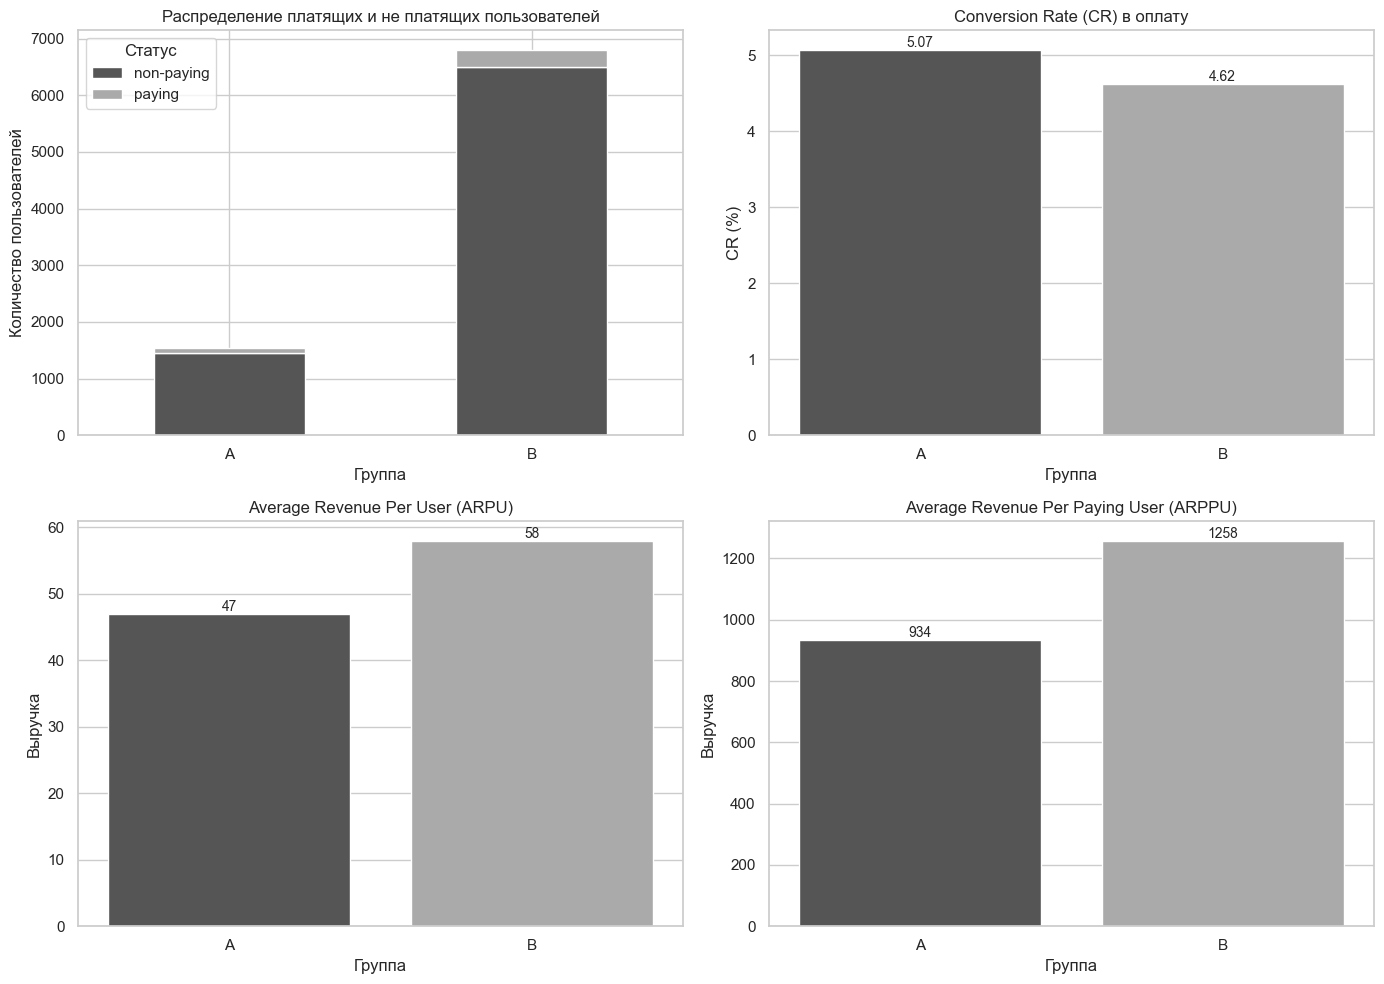

In [32]:
plot_metrics(groups_summary)

Распределение по группам неравномерное - тестовая в 4 раза больше. Это может повлиять на выводы. Если это не ошибка при проведении теста, нужно учитывать это при расчетах.

При этом конверсия в покупку в группах различается мало, в контрольной группе она даже немного больше. Зато у группы B средний чек заметно выше. Новая механика снижает конверсию, но у оставшихся клиентов чек увеличился, и ARPU всё равно вырос.

Нужно проверить, статистически значимы ли эти различия.

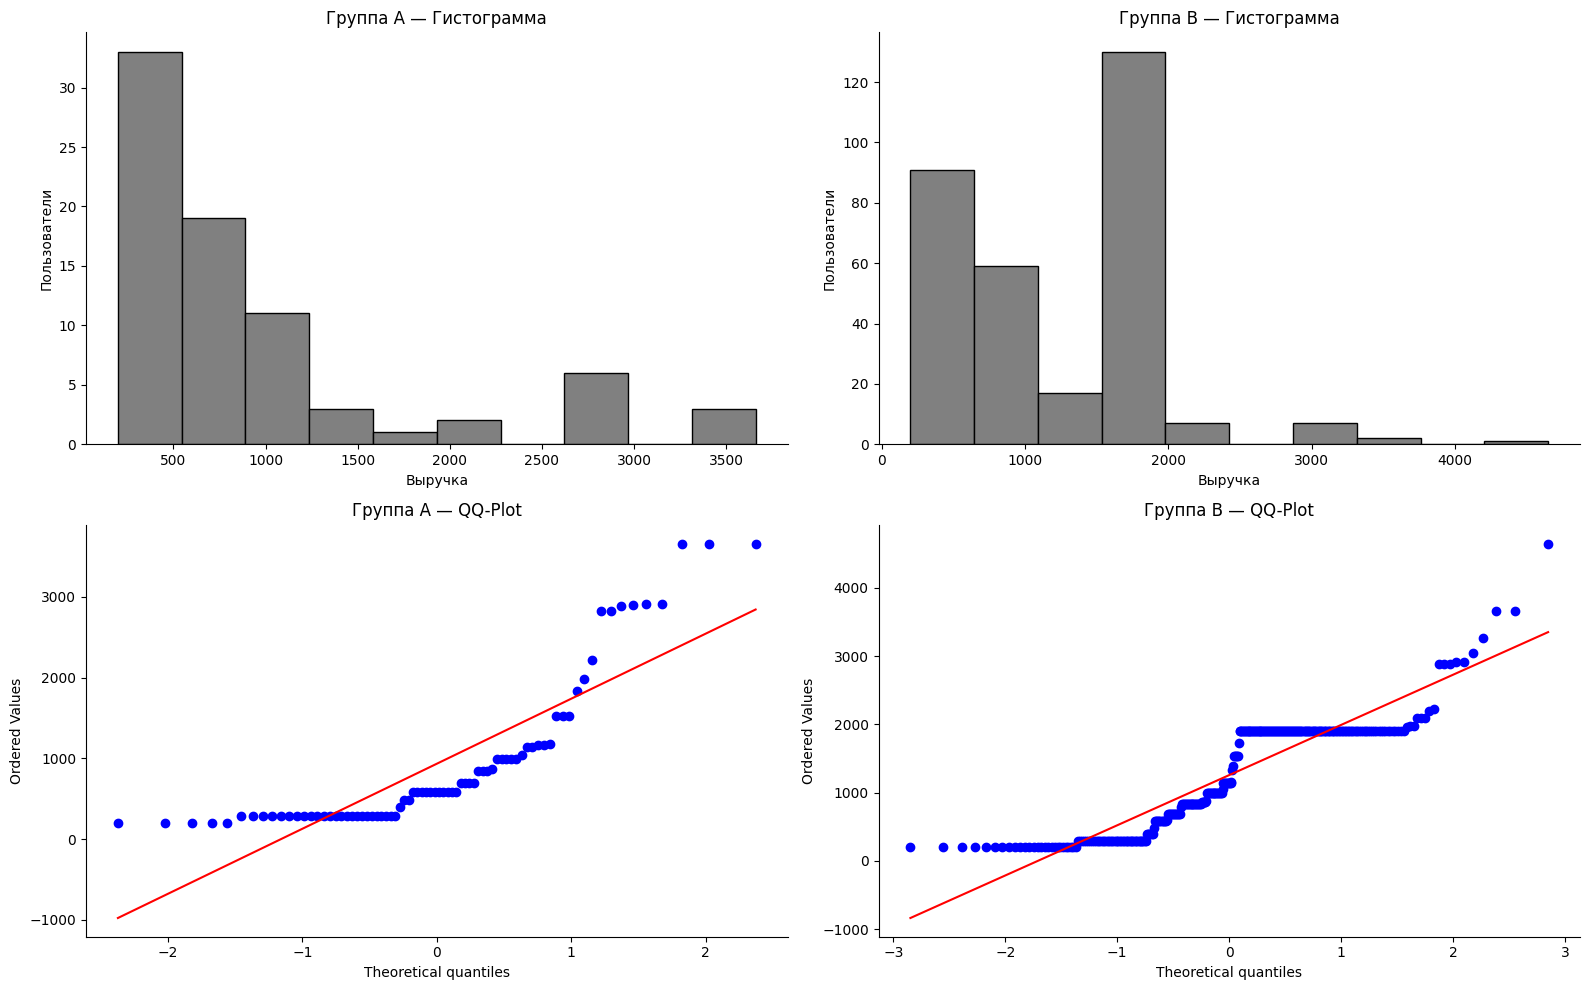

In [15]:
# Проверим распределения на нормальность. H0 - выручка распределна нормально.

# Для проверки на нормальность отфильтруем по группам пользователей

group_A = df.query("grp=='A'")
group_B = df.query("grp=='B'")

group_A_paying = df.query("is_paying == 'yes' and grp=='A'")
group_B_paying = df.query("is_paying == 'yes' and grp=='B'")

# Оценим визульно расспределение выручки по платящим пользователям

fig, axs = plt.subplots(2, 2, figsize=(16, 10))

# Гистограмма для группы A
axs[0, 0].hist(group_A_paying['rev'], color='gray', edgecolor='black')
axs[0, 0].set_title('Группа A — Гистограмма')
axs[0, 0].set(xlabel='Выручка', ylabel='Пользователи')

# Гистограмма для группы B 
axs[0, 1].hist(group_B_paying['rev'], color='gray', edgecolor='black')
axs[0, 1].set_title('Группа B — Гистограмма')
axs[0, 1].set(xlabel='Выручка', ylabel='Пользователи')

# QQ-plot для группы A
stats.probplot(group_A_paying['rev'], dist="norm", plot=axs[1, 0])
axs[1, 0].set_title('Группа A — QQ-Plot')

# QQ-plot для группы B
stats.probplot(group_B_paying['rev'], dist="norm", plot=axs[1, 1])
axs[1, 1].set_title('Группа B — QQ-Plot')

sns.despine()
plt.tight_layout()
plt.show()

In [29]:
# Проверим на нормальность с помощью теста Шапиро-Уилка, так как выборки небольшие.

# Проверка нормальности для группы A
result_a = pg.normality(group_A['rev'])
print("Группа A:")
print(result_a)

# Проверка нормальности для группы B
result_b = pg.normality(group_B['rev'])
print("Группа B:")
print(result_b)

Группа A:
            W          pval  normal
rev  0.154167  1.113974e-63   False
Группа B:
            W          pval  normal
rev  0.181244  2.287185e-99   False


По графиками и тестам оба распределения не нормальные, в группе B больше размер и размах выборки.

**Проверим статистическую значимость различий в метриках:**

Для проверки CR проведем Z-тест, так как это пропорции.

Для проверки ARPU и ARPPU (количественных метрик) проверим на гомоскедастичность, затем выберем, какой тест использовать.

### CR

**H0**: CR в тестовой и контрольной группах не различаются  
**H1**:  CR в тестовой и контрольной группах различаются  

In [17]:
# z-тест для CR

# Платящие
paying = groups_summary.paying.tolist()
# Все пользователи
all_users = groups_summary.all_users.tolist()

z_stat, p_value = proportions_ztest(paying, all_users)
print(f"p-value для доли платящих: {p_value:.4f}")

p-value для доли платящих: 0.4455


### Проверка гомогенности дисперсий

**H0**: Дисперсии в тестовой и контрольной группах не различаются  
**H1**: Дисперсии в тестовой и контрольной группах различаются  

In [18]:
# Тест Левена для проверки равенства дисперсий

rev_A = group_A.rev
rev_B = group_B.rev

levene_stat, levene_p = stats.levene(rev_A, rev_B)

print(f't-статистика: {levene_stat}')
print(f'p-значение: {levene_p}')


t-статистика: 1.501460829433639
p-значение: 0.22048133327049668


In [19]:
# Тест Левена для проверки равенства дисперсий платящих

rev_A_paying = group_A_paying.rev
rev_B_paying = group_B_paying.rev

levene_stat, levene_p = stats.levene(rev_A, rev_B)

print(f't-статистика: {levene_stat}')
print(f'p-значение: {levene_p}')


t-статистика: 1.501460829433639
p-значение: 0.22048133327049668


Поскольку в обоих случаях p-value > 0.05, нет оснований отвергать гипотезу о равенстве дисперсий.

То есть выборки можно считать гомогенными, и использовать t-тест для средних.

### ARPU

**H0**: ARPU в тестовой и контрольной группах не различаются  
**H1**: ARPU в тестовой и контрольной группах различаются  

In [20]:
# t-тест ARPU

ttest_arpu = pg.ttest(rev_A, rev_B, correction=False)

print("T-test для ARPU:\n", ttest_arpu)

T-test для ARPU:
                T   dof alternative     p-val           CI95%   cohen-d   BF10  \
T-test -1.225341  8339   two-sided  0.220481  [-27.85, 6.42]  0.034597  0.067   

           power  
T-test  0.231965  


### ARPPU

**H0**: ARPPU в тестовой и контрольной группах не различаются  
**H1**: ARPPU в тестовой и контрольной группах различаются  

In [21]:
# t-тест ARPPU

ttest_arppu = pg.ttest(rev_A_paying, rev_B_paying, correction=False)

print("T-test для ARPPU:\n", ttest_arppu)

T-test для ARPPU:
               T  dof alternative     p-val               CI95%  cohen-d  \
T-test -3.13378  390   two-sided  0.001856  [-527.74, -120.84]  0.39646   

          BF10     power  
T-test  14.001  0.878211  


**Выводы проверки на статистическую значимость:**

1. **CR** p-value = 0.4455, больше 0,05 —  не можем отвергнуть нулевую гипотезу о том, что значимых различий в конверсиях в оплату нет.
2. **ARPU** p-value = 0.2205, больше 0,05 —  не можем отвергнуть нулевую гипотезу о том, что значимых различий в среднем чеке на активного пользователя нет.
3. **ARPPU** p-value = 0.0019, меньше 0,05 — отвергаем нулевую гипотезу о том, что значимых различий в среднем чеке на платящего активного пользователя нет.

## Выводы

* В ходе анализа данных A/B-тестирования новой механики оплаты услуг на сайте были рассмотрены основные метрики - CR, ARPU, ARPPU, которые доллжны были показать, насколько новая механика влияет на склонность пользователя к оплате и выручку.
* В группе B (новая механика) конверсия немного ниже (4.62% против 5.07% у группы A). При этом ARPU выше (58 против 47), а ARPPU значительно выше (1258 против 934). Это может говорить о том, что новая механика оплаты сужает круг платящих, но увеличивает средний чек у тех, кто все же решился заплатить.
* Для CR и ARPU p-value > 0.05, что говорит о том, что различия не являются статистически значимыми. Для ARPPU p-value < 0.05, различие статистически значимо. Новая механика действительно увеличивает доход от одного платящего пользователя.
* Возможно, на эти различия влияет то, что размеры выборок сильно отличаются (1538 в группе А, 8630 в группе В), желательно повторить тест с более сбалансированным распределением пользователей между группами.

## Рекомендации

Несмотря на рост ARPPU, конверсия в тестовой группе снизилась, а общее влияние на ARPU не доказано статистически. Поэтому на основании данного теста новую механику на всех пользователей запускать не стоит, нужно дополнительно проанализировать поведение пользователей.